In [ ]:
! pip install torch torchvision pillow scikit-learn tqdm ultralytics transformers

  Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 2.4 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


In [47]:
! unzip train.zip

Archive:  train.zip
   creating: train/
   creating: train/img/
  inflating: train/img/O207KY51.png  
  inflating: train/img/O046PP46.png  
  inflating: train/img/B400CH159.png  
  inflating: train/img/H130PY46.png  
  inflating: train/img/O808OX39.png  
  inflating: train/img/T395EP154.png  
  inflating: train/img/K318BE46.png  
  inflating: train/img/H505TA199.png  
  inflating: train/img/P500AB77.png  
  inflating: train/img/M200TT199.png  
  inflating: train/img/B462TT53.png  
  inflating: train/img/A804XE44.png  
  inflating: train/img/K750EY125.png  
  inflating: train/img/P080EX34.png  
  inflating: train/img/C759XX93.png  
  inflating: train/img/H975CH26.png  
  inflating: train/img/O290HC78.png  
  inflating: train/img/O669OA98.png  
  inflating: train/img/T019OO71.png  
  inflating: train/img/E196BB761.png  
  inflating: train/img/B777BH34.png  
  inflating: train/img/K228AP790.png  
  inflating: train/img/E285KY99.png  
  inflating: train/img/P700OK34.png  
  inflating: trai

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageOps
from tqdm import tqdm

In [2]:
CHARS = "1234567890ABEKMHOPCTYX"
char2idx = {c: i + 1 for i, c in enumerate(CHARS)}  # 0 — blank
idx2char = {i: c for c, i in char2idx.items()}
BLANK_IDX = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class OCRDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label_text = os.path.splitext(img_name)[0]

        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        w, h = image.size
        if h < w:
            pad_total = w - h
            image = ImageOps.expand(image, (0, pad_total // 2, 0, pad_total - pad_total // 2), fill="white")
        elif w < h:
            pad_total = h - w
            image = ImageOps.expand(image, (pad_total // 2, 0, pad_total - pad_total // 2, 0), fill="white")

        if self.transform:
            image = self.transform(image)

        label = [char2idx[c] for c in label_text if c in char2idx]
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image, label_tensor, len(label), label_text

In [4]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.lstm = nn.LSTM(256 * 28, 256, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous().view(b, w, c * h)
        x, _ = self.lstm(x)
        x = self.classifier(x)
        return x.log_softmax(2)

In [5]:
def decode(preds):
    pred_idxs = torch.argmax(preds, dim=2).cpu().numpy()
    results = []
    for idx_seq in pred_idxs:
        output = []
        prev = -1
        for i in idx_seq:
            if i != prev and i != BLANK_IDX:
                output.append(idx2char.get(i, ""))
            prev = i
        results.append("".join(output))
    return results

In [6]:
def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels, lengths, label_texts in tqdm(dataloader, desc="Validation"):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            output = model(images)
            output = output.permute(1, 0, 2)

            input_lengths = torch.full(size=(output.size(1),), fill_value=output.size(0), dtype=torch.long).to(DEVICE)
            target_lengths = torch.tensor(lengths, dtype=torch.long).to(DEVICE)

            loss = criterion(output, labels, input_lengths, target_lengths)
            total_loss += loss.item()

            preds = output.permute(1, 0, 2)
            decoded_preds = decode(preds)
            for pred_str, true_str in zip(decoded_preds, label_texts):
                if pred_str == true_str:
                    total_correct += 1
            total_samples += len(label_texts)

    avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else 0
    accuracy = total_correct / total_samples if total_samples > 0 else 0
    return avg_loss, accuracy

In [7]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, patience=5, save_path="crnn_model.pth"):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for images, labels, lengths, label_texts in tqdm(train_loader, desc=f"Epoch {epoch+1} training"):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            output = model(images)
            output = output.permute(1, 0, 2)

            input_lengths = torch.full(size=(output.size(1),), fill_value=output.size(0), dtype=torch.long).to(DEVICE)
            target_lengths = torch.tensor(lengths, dtype=torch.long).to(DEVICE)

            loss = criterion(output, labels, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            with torch.no_grad():
                preds = output.permute(1, 0, 2)
                decoded_preds = decode(preds)
                for pred_str, true_str in zip(decoded_preds, label_texts):
                    if pred_str == true_str:
                        total_correct += 1
                total_samples += len(label_texts)

        train_loss = total_loss / len(train_loader)
        train_acc = total_correct / total_samples if total_samples > 0 else 0

        val_loss, val_acc = validate(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"Validation loss decreased, saving model to {save_path}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

In [8]:
def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.cat([item[1] for item in batch])
    lengths = [item[2] for item in batch]
    label_texts = [item[3] for item in batch]
    return images, labels, lengths, label_texts

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


full_dataset = OCRDataset("train/img", transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


model = CRNN(num_classes=len(char2idx) + 1).to(DEVICE)
criterion = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=5)

Validation: 100%|██████████| 473/473 [00:10<00:00, 44.21it/s]


Epoch 1/10 - Train Loss: 1.0398 | Train Acc: 0.5661 | Val Loss: 0.0912 | Val Acc: 0.9362
Validation loss decreased, saving model to crnn_model.pth


Validation: 100%|██████████| 473/473 [00:10<00:00, 44.24it/s]


Epoch 2/10 - Train Loss: 0.0826 | Train Acc: 0.9567 | Val Loss: 0.0648 | Val Acc: 0.9692
Validation loss decreased, saving model to crnn_model.pth


Validation: 100%|██████████| 473/473 [00:10<00:00, 44.01it/s]


Epoch 3/10 - Train Loss: 0.0737 | Train Acc: 0.9666 | Val Loss: 0.0673 | Val Acc: 0.9628


Validation: 100%|██████████| 473/473 [00:10<00:00, 44.19it/s]


Epoch 4/10 - Train Loss: 0.0691 | Train Acc: 0.9710 | Val Loss: 0.0616 | Val Acc: 0.9722
Validation loss decreased, saving model to crnn_model.pth


Validation: 100%|██████████| 473/473 [00:10<00:00, 44.32it/s]


Epoch 5/10 - Train Loss: 0.0653 | Train Acc: 0.9737 | Val Loss: 0.0603 | Val Acc: 0.9758
Validation loss decreased, saving model to crnn_model.pth


Validation: 100%|██████████| 473/473 [00:10<00:00, 43.59it/s]


Epoch 6/10 - Train Loss: 0.0628 | Train Acc: 0.9756 | Val Loss: 0.0586 | Val Acc: 0.9754
Validation loss decreased, saving model to crnn_model.pth


Validation: 100%|██████████| 473/473 [00:10<00:00, 43.83it/s]


Epoch 7/10 - Train Loss: 0.0613 | Train Acc: 0.9764 | Val Loss: 0.0558 | Val Acc: 0.9782
Validation loss decreased, saving model to crnn_model.pth


Validation: 100%|██████████| 473/473 [00:10<00:00, 44.11it/s]


Epoch 8/10 - Train Loss: 0.0607 | Train Acc: 0.9775 | Val Loss: 0.0558 | Val Acc: 0.9788


Validation: 100%|██████████| 473/473 [00:10<00:00, 44.27it/s]


Epoch 9/10 - Train Loss: 0.0595 | Train Acc: 0.9775 | Val Loss: 0.0566 | Val Acc: 0.9764


Validation: 100%|██████████| 473/473 [00:10<00:00, 43.85it/s]

Epoch 10/10 - Train Loss: 0.0575 | Train Acc: 0.9790 | Val Loss: 0.0569 | Val Acc: 0.9788


Найден номер: B605HC190


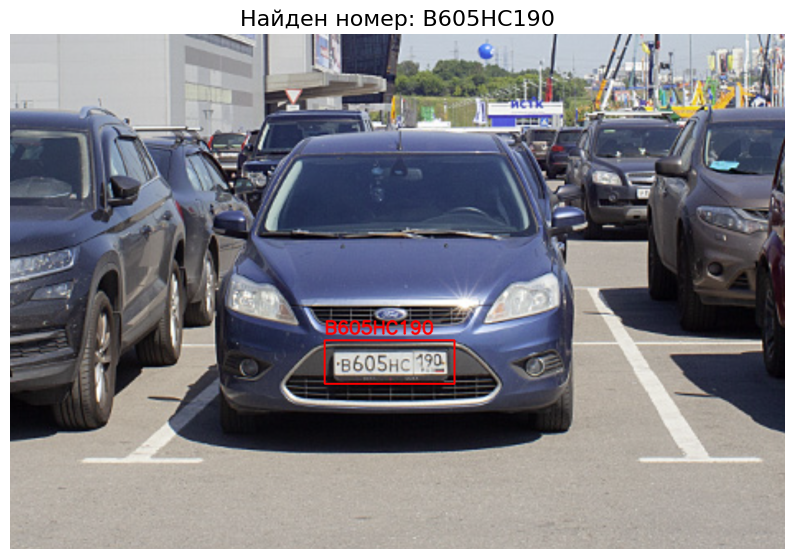

In [15]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np


CHARS = "1234567890ABEKMHOPCTYX"
char2idx = {c: i + 1 for i, c in enumerate(CHARS)}
idx2char = {i: c for c, i in char2idx.items()}
BLANK_IDX = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
        )
        self.lstm = nn.LSTM(256 * 28, 256, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2).contiguous().view(b, w, c * h)
        x, _ = self.lstm(x)
        x = self.classifier(x)
        return x.log_softmax(2)


def decode(preds):
    pred_idxs = torch.argmax(preds, dim=2).cpu().numpy()
    results = []
    for idx_seq in pred_idxs:
        output, prev = -1, -1
        text = []
        for i in idx_seq:
            if i != prev and i != BLANK_IDX:
                text.append(idx2char.get(i, ""))
            prev = i
        results.append("".join(text))
    return results


def pad_to_square(image):
    w, h = image.size
    if w == h:
        return image
    if h < w:
        pad_total = w - h
        padding = (0, pad_total // 2, 0, pad_total - pad_total // 2)
    else:
        pad_total = h - w
        padding = (pad_total // 2, 0, pad_total - pad_total // 2, 0)
    return ImageOps.expand(image, padding, fill="white")


def predict_plate_text(model, image):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    image = pad_to_square(image)
    with torch.no_grad():
        image_tensor = transform(image).unsqueeze(0).to(DEVICE)
        output = model(image_tensor)
        preds = decode(output)
        return preds[0] if preds else ""



crnn_model = CRNN(num_classes=len(char2idx) + 1).to(DEVICE)
crnn_model.load_state_dict(torch.load("crnn_model.pth", map_location=DEVICE))
crnn_model.eval()


cascade_path = cv2.data.haarcascades + "haarcascade_russian_plate_number.xml"
plate_cascade = cv2.CascadeClassifier(cascade_path)


image_path = "./image copy 7.png"
cv_image = cv2.imread(image_path)
gray = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)

plates = plate_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)


if len(plates) == 0:
    print("⚠️ Номерная табличка не найдена.")
else:
    for (x, y, w, h) in plates:
        cropped = cv_image[y:y+h, x:x+w]
        pil_cropped = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

        plate_text = predict_plate_text(crnn_model, pil_cropped)
        print(f"Найден номер: {plate_text}")

        cv2.rectangle(cv_image, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.putText(cv_image, plate_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.9, (0, 0, 255), 2, cv2.LINE_AA)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Найден номер: {plate_text}", fontsize=16)
    plt.show()


In [ ]:
import torch


onnx_path = "crnn_model.onnx"
dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)


crnn_model.eval()
torch.onnx.export(
    crnn_model,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"}, 
        "output": {0: "batch_size", 1: "sequence"}
    },
    opset_version=11,
    do_constant_folding=True
)

print(f"Модель экспортирована в ONNX: {onnx_path}")


/home/thread554/VSCodeProjects/CarPlatesRecognition/venv/lib/python3.12/site-packages/torch/onnx/symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


Модель экспортирована в ONNX: crnn_model.onnx


In [17]:
import onnx
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print("Проверка пройдена")

Проверка пройдена
